<a href="https://colab.research.google.com/github/keto08/covid-19/blob/master/south_korea_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('korea_patient_info.csv')

In [ ]:
df.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [ ]:
df['contact_number'].isna().sum()

4374

In [ ]:
df['infected_by'].isna().count()

5165

In [ ]:
df[~df['infected_by'].isna()]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released
5,1000000006,female,50s,Korea,Seoul,Jongno-gu,contact with patient,1000000003,43,NaN,2020-01-31,2020-02-19,NaN,released
6,1000000007,male,20s,Korea,Seoul,Jongno-gu,contact with patient,1000000003,0,NaN,2020-01-31,2020-02-10,NaN,released
9,1000000010,female,60s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000003,6,NaN,2020-02-05,2020-02-29,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5116,6100000104,female,70s,Korea,Gyeongsangnam-do,Sancheong-gun,etc,6100000097,NaN,2020-03-26,2020-03-31,NaN,NaN,released
5123,6100000111,male,20s,Korea,Gyeongsangnam-do,Sacheon-si,contact with patient,6100000108,NaN,2020-04-04,2020-04-06,NaN,NaN,released
5124,6100000112,male,60s,Korea,Gyeongsangnam-do,Hapcheon-gun,contact with patient,6100000100,NaN,2020-04-03,2020-04-07,NaN,NaN,released
5126,6100000114,female,0s,Korea,Gyeongsangnam-do,Jinju-si,overseas inflow,6100000103,NaN,2020-04-01,2020-04-08,NaN,NaN,released


In [10]:
url = 'https://raw.githubusercontent.com/keto08/covid-19/master/korea_patient_info.csv'
df1 = pd.read_csv(url)

In [11]:
df1

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160,7000000015,female,30s,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,25,NaN,2020-05-30,2020-06-13,NaN,released
5161,7000000016,NaN,NaN,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-16,2020-06-24,NaN,released
5162,7000000017,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,72,NaN,2020-06-18,NaN,NaN,isolated
5163,7000000018,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-18,NaN,NaN,isolated


In [12]:
df1.shape

(5165, 14)

In [13]:
df1.patient_id.nunique()

5164

In [14]:
df1.infected_by.count()

1346

In [15]:
df1.infection_case.value_counts()

contact with patient                             1610
overseas inflow                                   840
etc                                               703
Itaewon Clubs                                     162
Richway                                           128
Guro-gu Call Center                               112
Shincheonji Church                                107
Coupang Logistics Center                           80
Yangcheon Table Tennis Club                        44
Day Care Center                                    43
SMR Newly Planted Churches Group                   36
Onchun Church                                      33
Bonghwa Pureun Nursing Home                        31
gym facility in Cheonan                            30
Ministry of Oceans and Fisheries                   28
Wangsung Church                                    24
Cheongdo Daenam Hospital                           21
Dongan Church                                      17
Eunpyeong St. Mary's Hospita

In [16]:
df1.contact_number.count()

791

In [18]:
df1.contact_number.value_counts()

3      96
2      92
1      87
0      83
4      51
       ..
32      1
89      1
35      1
130     1
156     1
Name: contact_number, Length: 88, dtype: int64

In [20]:
df1.infected_by.value_counts()

2000000205    51
4100000008    27
1400000209    24
2000000167    24
4100000006    21
              ..
1000000068     1
2000000393     1
1400000035     1
1600000008     1
1100000078     1
Name: infected_by, Length: 606, dtype: int64

In [21]:
df1.sex.value_counts()

female    2218
male      1825
Name: sex, dtype: int64

In [22]:
df1.age.value_counts()

20s     899
50s     667
30s     523
40s     518
60s     482
70s     232
10s     178
80s     170
0s       66
90s      49
100s      1
Name: age, dtype: int64

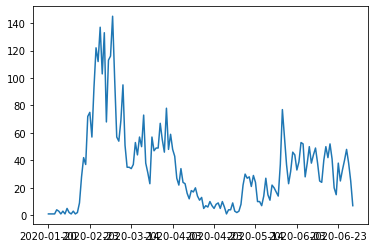

In [27]:
df1.confirmed_date.value_counts().sort_index().plot()
plt.show()